In [ ]:
!pip install helperfns -q

In [290]:
import random
import time
import torch
import warnings 

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string

warnings.filterwarnings("ignore")
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.3.0
numpy:  1.26.4
pandas:  2.1.4


In [11]:
COLORS = ['#638C6D', '#E7FBB4', '#DF6D2D', '#4C585B', '#474E93', '#D8C4B6', '#118B50']

In [6]:
SEED = 23

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
dataframe = pd.read_csv("crop_yield_data.csv")
dataframe.head(2)

,rainfall_mm,soil_quality_index,farm_size_hectares,sunlight_hours,fertilizer_kg,crop_yield
0,1626,9,636,11,1006,404
1,1959,9,73,11,112,115


In [31]:
dataframe.isna().any()

rainfall_mm           False
soil_quality_index    False
farm_size_hectares    False
sunlight_hours        False
fertilizer_kg         False
crop_yield            False
dtype: bool

In [33]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   rainfall_mm         3000 non-null   int64
 1   soil_quality_index  3000 non-null   int64
 2   farm_size_hectares  3000 non-null   int64
 3   sunlight_hours      3000 non-null   int64
 4   fertilizer_kg       3000 non-null   int64
 5   crop_yield          3000 non-null   int64
dtypes: int64(6)
memory usage: 140.8 KB


In [35]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
rainfall_mm,3000.0,1263.095000,432.371756,500.0,896.00,1277.0,1636.0,2000.0
soil_quality_index,3000.0,5.506667,2.855172,1.0,3.00,6.0,8.0,10.0
farm_size_hectares,3000.0,498.801000,287.122742,10.0,242.00,505.0,741.0,1000.0
sunlight_hours,3000.0,7.995333,2.621501,4.0,6.00,8.0,10.0,12.0
fertilizer_kg,3000.0,1549.450333,814.326919,100.0,869.75,1542.0,2225.0,3000.0
crop_yield,3000.0,328.099000,145.036503,46.0,199.00,332.0,455.0,628.0


In [143]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=SEED)
train_df, val_df = train_test_split(dataframe, test_size=0.2, random_state=SEED)

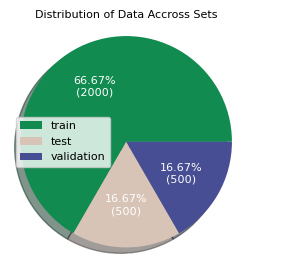

In [55]:
dist_sets = {'train': len(train_df), 'test': len(test_df), "validation": len(val_df)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.title("Distribution of Data Accross Sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .0, .0],
    colors=COLORS[::-1], shadow=True,
)
plt.axis('equal')
plt.legend(fontsize=8)
plt.show()

In [145]:
X_train = train_df.drop(columns=['crop_yield'])
X_val = val_df.drop(columns=['crop_yield'])
X_test = test_df.drop(columns=['crop_yield'])

y_train = train_df.crop_yield.values
y_val = val_df.crop_yield.values
y_test = test_df.crop_yield.values

In [147]:
y_train[:2]

array([361, 356], dtype=int64)

In [149]:

std_scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])

label_transformer = MinMaxScaler()

ct = ColumnTransformer([
    ("std-columns", std_scale_pipeline,  X_train.columns),
])

y_train = label_transformer.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test = label_transformer.transform(y_test.reshape(-1, 1)).squeeze()
y_val = label_transformer.transform(y_val.reshape(-1, 1)).squeeze()

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
X_val = ct.transform(X_val)

In [203]:
class CropYieldDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super(CropYieldDataset, self).__init__()
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    def __str__(self):
        return f"CropYieldDataset: ({len(self.y)} samples)"

In [205]:
class ToTensor():
    def __call__(self, sample):
        x, y = sample
        return torch.tensor(x.astype('float32')), torch.tensor(y.astype('float32'))

In [207]:
train_dataset = CropYieldDataset(X_train, y_train, transform=ToTensor())
test_dataset = CropYieldDataset(X_test, y_test, transform=ToTensor())
val_dataset = CropYieldDataset(X_val, y_val, transform=ToTensor())

In [209]:
print(train_dataset)

CropYieldDataset: (2400 samples)


In [211]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [213]:
features, labels = next(iter(train_loader))

In [215]:
labels

tensor([0.3746, 0.7680, 0.4192, 0.2526, 0.4931, 0.8351, 0.0945, 0.0911, 0.7491,
        0.0928, 0.8625, 0.1271, 0.3436, 0.4639, 0.0430, 0.3471, 0.4794, 0.3814,
        0.1701, 0.1667, 0.5052, 0.7062, 0.3299, 0.1151, 0.6426, 0.3694, 0.2320,
        0.6392, 0.5636, 0.3952, 0.1649, 0.2577, 0.8385, 0.2595, 0.2148, 0.2869,
        0.6460, 0.6718, 0.7766, 0.7818, 0.9055, 0.3814, 0.1289, 0.0911, 0.4399,
        0.2766, 0.6289, 0.7938, 0.5825, 0.8007, 0.3402, 0.1890, 0.4347, 0.8557,
        0.1770, 0.4227, 0.7869, 0.1203, 0.2732, 0.6014, 0.3041, 0.4450, 0.3213,
        0.6100, 0.3866, 0.4210, 0.4278, 0.5309, 0.1289, 0.2251, 0.6924, 0.1649,
        0.1873, 0.1821, 0.5481, 0.4502, 0.2818, 0.3780, 0.7921, 0.7182, 0.1684,
        0.7302, 0.5034, 0.7113, 0.6615, 0.8849, 0.1082, 0.7938, 0.5498, 0.5619,
        0.8832, 0.7835, 0.7818, 0.0911, 0.5069, 0.3711, 0.6306, 0.3488, 0.3643,
        0.1306, 0.2268, 0.5137, 0.1735, 0.9330, 0.9433, 0.3368, 0.7027, 0.8540,
        0.7560, 0.8866, 0.5808, 0.3694, 

In [217]:
features[0]

tensor([ 0.5760,  1.2084, -0.4933,  0.3732, -0.5086])

In [237]:
class CropYieldRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=.5):
        super(CropYieldRegressor, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Linear(128, output_dim)
        )
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(self.out(x))
        return x

In [306]:
INPUT_DIM = features.size()[1]
DROPOUT = .78
OUTPUT_DIM = 1
regressor = CropYieldRegressor(
    input_dim = INPUT_DIM, output_dim = OUTPUT_DIM, dropout = DROPOUT
).to(device)
regressor

CropYieldRegressor(
  (out): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.78, inplace=False)
)

In [308]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["regressor", *count_trainable_params(regressor)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-----------+--------------+------------------+
| MODEL     | TOTAL PARAMS | TRAINABLE PARAMS |
+-----------+--------------+------------------+
| regressor |          897 |              897 |
+-----------+--------------+------------------+


In [310]:
optimizer = torch.optim.Adam(regressor.parameters())
criterion = nn.MSELoss().to(device)

In [312]:
def train(model, iterator, optimizer, criterion):
    mse, mae, r2score = 0, 0, 0
    model.train()
    for batch in iterator:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(X).squeeze(1)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        mse += loss.item()
        mae += mean_absolute_error(y, predictions.detach().cpu())
        r2score += r2_score(y, predictions.detach().cpu())
    return mse / len(iterator), mae / len(iterator), r2score / len(iterator)

def evaluate(model, iterator, criterion):
    mse, mae, r2score = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            predictions = model(X).squeeze(1)
            loss = criterion(predictions, y)
            mse += loss.item()
            mae += mean_absolute_error(y, predictions.detach().cpu())
            r2score += r2_score(y, predictions.detach().cpu())
    return mse / len(iterator), mae / len(iterator), r2score / len(iterator)

In [314]:
class History:
    def __init__(self):
        self.train_mse = list()
        self.train_r2Score = list()
        self.train_mae = list()
        self.epoch_train_time = list()
        self.val_mse = list()
        self.val_r2Score = list()
        self.val_mae = list()
    
    def add(
        self, train_mse:float, train_mae:float, train_r2score: float, 
        val_mse:float, val_mae:float, val_r2score: float, ett:float
        ):
        self.train_mse.append(train_mse)
        self.train_mae.append(train_mae)
        self.train_r2Score.append(train_r2score)
        self.val_mse.append(val_mse)
        self.val_mae.append(val_mae)
        self.val_r2Score.append(val_r2score)
        self.epoch_train_time.append(ett)

In [316]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=100, log_at=10, optimizer=None, criterion=None):
    best_valid_loss = float('inf')
    last_saved_epoch = 1
    history = History()
    training_start = time.time()
    for epoch in range(epochs):
        start = time.time()
        train_mse, train_mae, train_r2score = train(model, train_loader, optimizer, criterion)
        valid_mse, valid_mae, valid_r2score = evaluate(model, val_loader, criterion)
        title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_mse < best_valid_loss else 'not saving...'}"
        if valid_mse < best_valid_loss:
            best_valid_loss = valid_mse
            torch.save(model.state_dict(), model_name)
            last_saved_epoch = epoch+1
        end = time.time()
        history.add(train_mse, train_mae, train_r2score, valid_mse, valid_mae, valid_r2score, end-start)
        if epoch % log_at == 0:
            data = [
                ["Training", f'{train_mse:.3f}', f'{train_mae:.3f}', f'{train_r2score:.3f}',f"{hms_string(end - start)}" ],
                ["Validation", f'{valid_mse:.3f}', f'{valid_mae:.3f}', f'{valid_r2score:.3f}', '' ],
            ]
            columns = ["CATEGORY", "MSE", "MAE", "R2_SCORE", "ETT"]
            tabulate_data(columns, data, title)
        
    training_end = time.time()
    return history, training_end - training_start, last_saved_epoch

In [318]:
EPOCHS = 100

history, ett, last_saved_epoch = run_train_loop(
    regressor, 'best-model.pt', train_loader, val_loader, EPOCHS, log_at = 10,
    optimizer=optimizer, criterion=criterion
)
     

EPOCH: 01/100 saving best model...
+------------+-------+-------+----------+------------+
| CATEGORY   |   MSE |   MAE | R2_SCORE |        ETT |
+------------+-------+-------+----------+------------+
| Training   | 0.306 | 0.464 |   -3.990 | 0:00:00.41 |
| Validation | 0.130 | 0.320 |   -1.174 |            |
+------------+-------+-------+----------+------------+
EPOCH: 11/100 not saving...
+------------+-------+-------+----------+------------+
| CATEGORY   |   MSE |   MAE | R2_SCORE |        ETT |
+------------+-------+-------+----------+------------+
| Training   | 0.231 | 0.376 |   -2.760 | 0:00:00.17 |
| Validation | 0.179 | 0.377 |   -2.006 |            |
+------------+-------+-------+----------+------------+
EPOCH: 21/100 not saving...
+------------+-------+-------+----------+------------+
| CATEGORY   |   MSE |   MAE | R2_SCORE |        ETT |
+------------+-------+-------+----------+------------+
| Training   | 0.233 | 0.379 |   -2.800 | 0:00:00.17 |
| Validation | 0.179 | 0.377 

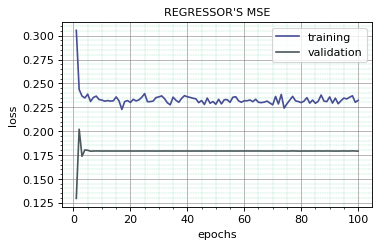

In [323]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_mse, color=COLORS[-3], label='training')
plt.plot(epochs, history.val_mse, color=COLORS[3], label='validation')

plt.title("REGRESSOR'S MSE", color="k", fontsize=10)
plt.xlabel("epochs", fontsize=10)
plt.ylabel("loss", fontsize=10)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

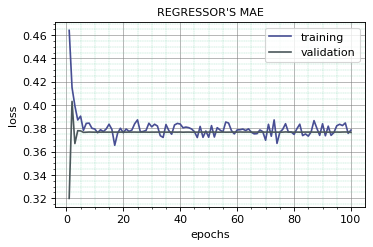

In [325]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_mae, color=COLORS[-3], label='training')
plt.plot(epochs, history.val_mae, color=COLORS[3], label='validation')

plt.title("REGRESSOR'S MAE", color="k", fontsize=10)
plt.xlabel("epochs", fontsize=10)
plt.ylabel("loss", fontsize=10)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

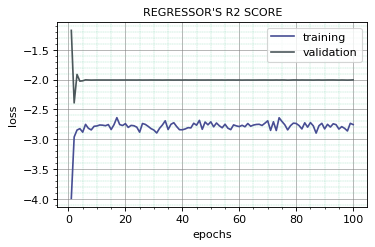

In [327]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_r2Score, color=COLORS[-3], label='training')
plt.plot(epochs, history.val_r2Score, color=COLORS[3], label='validation')

plt.title("REGRESSOR'S R2 SCORE", color="k", fontsize=10)
plt.xlabel("epochs", fontsize=10)
plt.ylabel("loss", fontsize=10)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()